In [101]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from matplotlib import cm

In [102]:
def U_set_boundary(U):
    U[0, :]  = 0
    U[:, 0]  = 0
    U[:, -1] = 0
    U[-1, :] = 1    # set velocity on cavity lid equal to 1
    return

def U_timestep(U,V,P):
    assert U.shape == V.shape and U.shape == P.shape
    U_next = U.copy()
    # First term
    ker = np.array([[0,0,0],
                    [-1,1,0],
                    [0,0,0]])
    U_next[1:-1,1:-1] -= DT/DX * U[1:-1,1:-1] * convolve2d(U,ker,mode="valid") # * is pointwise multiply matrice
    # Second term
    ker = np.array([[0,-1,0],
                    [0,1,0],
                    [0,0,0]])
    U_next[1:-1,1:-1] -= DT/DY * V[1:-1,1:-1] * convolve2d(U,ker,mode="valid")
    # Third term
    ker = np.array([[0,0,0],
                    [-1,0,1],
                    [0,0,0]])
    U_next[1:-1,1:-1] += DT/(2*RHO*DX) * convolve2d(P,ker,mode="valid")
    # Fourth term
    ker = np.array([[0,        DT/DY**2,                 0],
                    [DT/DX**2, -2*DT/DX**2 - 2*DT/DY**2, DT/DX**2],
                    [0,        DT/DY**2,                 0]])
    U_next[1:-1,1:-1] += NU * convolve2d(U,ker,mode="valid")
    U_set_boundary(U_next)
    return U_next

In [103]:
def V_set_boundary(V):
    V[0, :]  = 0
    V[-1, :] = 0
    V[:, 0]  = 0
    V[:, -1] = 0
    return

def V_timestep(U,V,P):
    assert U.shape == V.shape and U.shape == P.shape
    V_next = V.copy()
    # First term
    ker = np.array([[0,0,0],
                    [-1,1,0],
                    [0,0,0]])
    V_next[1:-1,1:-1] -= DT/DX * U[1:-1,1:-1] * convolve2d(V,ker,mode="valid") # * is pointwise multiply matrice
    # Second term
    ker = np.array([[0,-1,0],
                    [0,1,0],
                    [0,0,0]])
    V_next[1:-1,1:-1] -= DT/DY * V[1:-1,1:-1] * convolve2d(V,ker,mode="valid")
    # Third term
    ker = np.array([[0,-1,0],
                    [0,0,0],
                    [0,1,0]])
    V_next[1:-1,1:-1] += DT/(2*RHO*DX) * convolve2d(P,ker,mode="valid")
    # Fourth term
    ker = np.array([[0,        DT/DY**2,                 0],
                    [DT/DX**2, -2*DT/DX**2 - 2*DT/DY**2, DT/DX**2],
                    [0,        DT/DY**2,                 0]])
    V_next[1:-1,1:-1] += NU * convolve2d(V,ker,mode="valid")
    V_set_boundary(V_next)
    return V_next

In [109]:
def P_set_boundary(P):
    ### Boundary
    P[:, -1] = P[:, -2] # dp/dx = 0 at x = 2
    P[0, :] = P[1, :]   # dp/dy = 0 at y = 0
    P[:, 0] = P[:, 1]   # dp/dx = 0 at x = 0
    P[-1, :] = 0        # p = 0 at y = 2
    return

def P_poisson(U,V,P):
    assert U.shape == V.shape and U.shape == P.shape
    P_next = np.zeros(P.shape)
    ### Interior
    # First term, poisson term
    ker = np.array([[0,DX**2,0],
                    [DY**2,0,DY**2],
                    [0,DX**2,0]]) / (2 * (DX**2 + DY**2))
    P_next[1:-1,1:-1] += convolve2d(P,ker,mode="valid")
    # All subsequent terms are multiplied by the following constant
    CST = RHO * DX**2 * DY**2 / (2*(DX**2 + DY**2))
    # Second term, 1
    ker_dx = np.array([[0,0,0],
                    [-1,0,1],
                    [0,0,0]])
    P_next[1:-1,1:-1] -= CST / (2*DT*DX) * convolve2d(U,ker,mode="valid")
    # Second term, 2
    ker_dy = np.array([[0,-1,0],
                    [0,0,0],
                    [0,1,0]]) 
    P_next[1:-1,1:-1] -= CST / (2*DT*DY) * convolve2d(V,ker,mode="valid")
    # Third term, 1
    P_next[1:-1,1:-1] += CST / (4*DX*DX) * np.square(convolve2d(U,ker_dx,mode="valid"))
    # Third term, 2
    P_next[1:-1,1:-1] += 2 * CST / (4*DX*DY) * convolve2d(U,ker_dy,mode="valid") * convolve2d(V,ker_dx,mode="valid")
    # Third term, 3
    P_next[1:-1,1:-1] += CST / (4*DY*DY) * np.square(convolve2d(V,ker,mode="valid"))
    return P_next

In [110]:
def cavity_flow_timestep(U,V,P):
    P_next = P_poisson(U,V,P)
    U_next = U_timestep(U,V,P_next)
    
    V_next = V_timestep(U,V,P_next)
    return U_next,V_next,P_next

In [111]:
PI = np.pi
DX = 1/20
DY = 1/20
DT = 0.001
RHO = 1 # density constant
NU = 1 # unit conversion constant for double derivatives thingy
x_axis,y_axis = np.arange(0,2,DX), np.arange(0,2,DY) # axes
shape = (len(x_axis),len(y_axis))
X = np.outer(x_axis,np.ones(shape[1]))
Y = np.outer(np.ones(shape[0]),y_axis)

In [112]:
U,V,P = np.zeros(shape),np.zeros(shape),np.zeros(shape)
for i in range(100):
    U,V,P = cavity_flow_timestep(U,V,P)

/var/folders/25/p7w3csj93c5cz89r8vd6tyjw0000gn/T/ipykernel_19164/3620424429.py:31: RuntimeWarning: overflow encountered in square
  P_next[1:-1,1:-1] += CST / (4*DX*DX) * np.square(convolve2d(U,ker_dx,mode="valid"))
/var/folders/25/p7w3csj93c5cz89r8vd6tyjw0000gn/T/ipykernel_19164/3620424429.py:33: RuntimeWarning: overflow encountered in multiply
  P_next[1:-1,1:-1] += 2 * CST / (4*DX*DY) * convolve2d(U,ker_dy,mode="valid") * convolve2d(V,ker_dx,mode="valid")
/var/folders/25/p7w3csj93c5cz89r8vd6tyjw0000gn/T/ipykernel_19164/3620424429.py:33: RuntimeWarning: invalid value encountered in add
  P_next[1:-1,1:-1] += 2 * CST / (4*DX*DY) * convolve2d(U,ker_dy,mode="valid") * convolve2d(V,ker_dx,mode="valid")
/var/folders/25/p7w3csj93c5cz89r8vd6tyjw0000gn/T/ipykernel_19164/3620424429.py:35: RuntimeWarning: overflow encountered in square
  P_next[1:-1,1:-1] += CST / (4*DY*DY) * np.square(convolve2d(V,ker,mode="valid"))
/var/folders/25/p7w3csj93c5cz89r8vd6tyjw0000gn/T/ipykernel_19164/3326938590.p

/var/folders/25/p7w3csj93c5cz89r8vd6tyjw0000gn/T/ipykernel_19164/1228902255.py:6: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, P, cmap=cm.viridis)


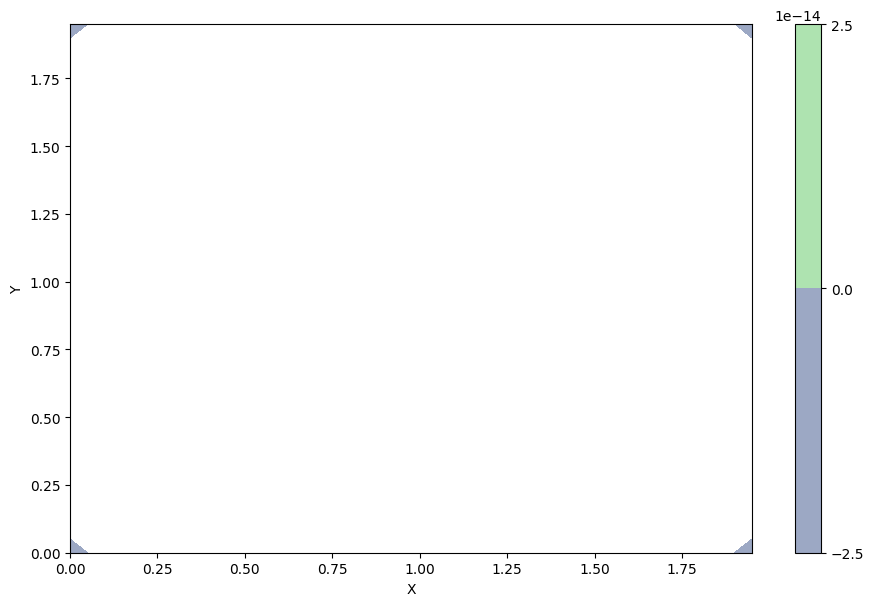

In [113]:
fig = plt.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, P, alpha=0.5, cmap=cm.viridis)  
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X, Y, P, cmap=cm.viridis)  
# plotting velocity field
plt.quiver(X[::2, ::2], Y[::2, ::2], U[::2, ::2], V[::2, ::2]) 
plt.xlabel('X')
plt.ylabel('Y');